In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"
train_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
test_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

# Чтение данных из CSV-файлов
data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [3]:
data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
# data = data.append(lost_intent, ignore_index = True)
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   intent  4978 non-null   object
 1   text    4978 non-null   object
dtypes: object(2)
memory usage: 77.9+ KB


In [5]:
from sklearn.model_selection import train_test_split
import timeit

train, test = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
# # Подсчитываем количество примеров для каждого класса
# class_counts = train['intent'].value_counts()

# # Находим класс с наименьшим количеством примеров
# min_class = class_counts.idxmin()
# min_class_count = class_counts.min()

# # Делаем undersampling для всех остальных классов
# balanced_data = train[train['intent'] == min_class]
# for intent in class_counts.index:
#     if intent != min_class:
#         samples = train[train['intent'] == intent].sample(min_class_count)
#         balanced_data = pd.concat([balanced_data, samples], axis=0)

# # Теперь в balanced_data примеры каждого класса представлены в одинаковом количестве
# train = balanced_data

In [7]:
unique_values_normalized = train['intent'].value_counts(normalize=True)
print(unique_values_normalized*100)

intent
atis_flight                                 73.304872
atis_airfare                                 8.538423
atis_ground_service                          4.897037
atis_airline                                 3.340030
atis_abbreviation                            3.063787
atis_aircraft                                1.707685
atis_quantity                                1.130085
atis_flight_time                             1.029633
atis_flight#atis_airfare                     0.452034
atis_distance                                0.426921
atis_airport                                 0.401808
atis_ground_fare                             0.376695
atis_city                                    0.351582
atis_capacity                                0.351582
atis_flight_no                               0.301356
atis_meal                                    0.125565
atis_restriction                             0.100452
atis_ground_service#atis_ground_fare         0.025113
atis_airline#atis_fli

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

In [9]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# from pymystem3 import Mystem

# # Создаем экземпляр класса Mystem
# m = Mystem()

# # Текст для токенизации
# text = "Ваш текст для токенизации"

# # Применяем токенизацию
# tokens = m.lemmatize(text)

# print('Токены:', tokens)
# # Токенизация текста
# data['text'] = data['text'].apply(lambda x: m.lemmatize(x))


In [11]:
# Создание пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: tokenizer.encode(x, add_special_tokens=True))),
    ('lr', LogisticRegression(C=1.0, max_iter=150, penalty='l2'))  
])

# Обучение пайплайна
pipeline.fit(train['text'], train['intent'])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7de22a7c9f30>)),
                ('lr', LogisticRegression(max_iter=150))])

In [12]:
start_test = timeit.default_timer()
# Прогноз на тестовом наборе
predictions = pipeline.predict(test['text'])
end_test = timeit.default_timer()
# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

Time for testing: 0.6754 seconds
Average time per response: 0.000678 seconds


In [13]:
balanced_accuracy_score(test['intent'], predictions)

0.3500476264030481

In [14]:
precision_recall_fscore_support(test['intent'], predictions, average = 'weighted')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9021588443418788, 0.927710843373494, 0.9113628615902597, None)

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

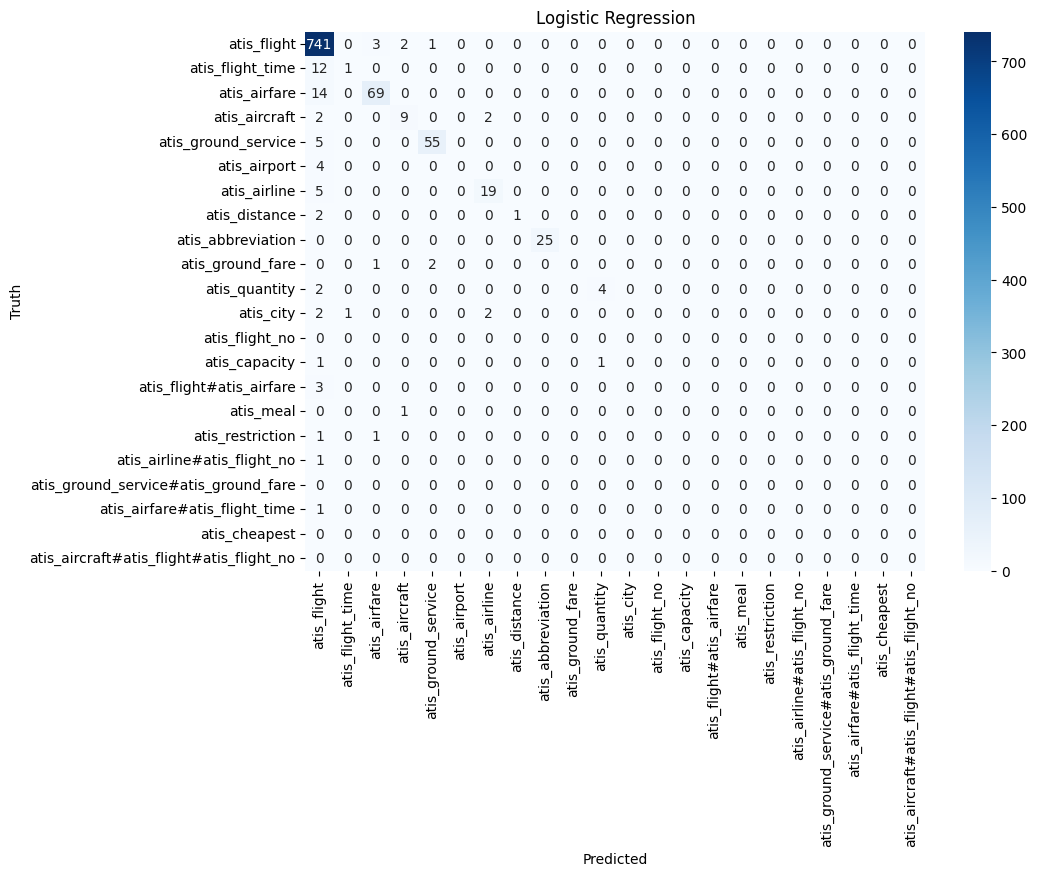

In [16]:
# Построение confusion matrix
labels = data['intent'].unique()  # получите уникальные метки классов
cm = confusion_matrix(test['intent'], predictions, labels=labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title(f'Logistic Regression')
plt.show()